# Group Lab 3

## Import

In [3]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from IPython.display import display
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from matplotlib.patches import Patch
from sklearn.manifold import TSNE

## Load the Dataset

In [5]:
# load in the IMDB movie dataset
df = pd.read_csv('imdb_top_1000.csv')

# display the dataset info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Poster_Link    1000 non-null   object 
 1   Series_Title   1000 non-null   object 
 2   Released_Year  1000 non-null   object 
 3   Certificate    899 non-null    object 
 4   Runtime        1000 non-null   object 
 5   Genre          1000 non-null   object 
 6   IMDB_Rating    1000 non-null   float64
 7   Overview       1000 non-null   object 
 8   Meta_score     843 non-null    float64
 9   Director       1000 non-null   object 
 10  Star1          1000 non-null   object 
 11  Star2          1000 non-null   object 
 12  Star3          1000 non-null   object 
 13  Star4          1000 non-null   object 
 14  No_of_Votes    1000 non-null   int64  
 15  Gross          831 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory usage: 125.1+ KB
None


## Preprocessing

### Create a copy of the dataframe.

In [8]:
df1 = df.copy()

### Drop any columns deemed unnecessary.

In [10]:
df1.drop(columns=['Poster_Link', 'Overview', 'Director', 'Star1', 'Star2', 'Star3', 'Star4'], inplace=True)

### String normalization and missing value handling.

In [12]:
# remove or swap special characters
df1['Certificate'] = df1['Certificate'].str.replace('/', '', regex=False)
df1['Certificate'] = df1['Certificate'].str.replace('-', '_', regex=False)
df1['Genre'] = df1['Genre'].str.replace('-', '_', regex=False)
df1['Gross'] = df1['Gross'].str.replace(',', '')
df1['Runtime'] = df1['Runtime'].str.replace(' min', '', regex=False)

# remove any whitespaces in the certificate column
df1['Certificate'] = df1['Certificate'].str.strip()

# handle missing values in the certificate column by filling with a placeholder string
df1['Certificate'] = df1['Certificate'].fillna('Unrated')

# handle missing values in meta score by filling with the imdb rating
df1['Meta_score'] = df1['Meta_score'].fillna(df1['IMDB_Rating'] * 10)

# standardize genre types (specifically musical)
df1['Genre'] = df1['Genre'].str.replace(r'\bMusic\b', 'Musical', regex=True)

"""
standardize certificate ratings using the following sites as guidance
https://www.filmratings.com/
https://clevelandmedia.weebly.com/uploads/4/5/4/8/4548166/comparing_film_rating_systems_around_the_world.pdf
"""
# GP was replaced by PG starting in 1972
df1['Certificate'] = df1['Certificate'].str.replace('GP', 'PG', regex=False)
df1['Certificate'] = df1['Certificate'].str.replace('TV_PG', 'PG', regex=False)
# U seems to stand for Universal where G stands for General Audiences
df1['Certificate'] = df1['Certificate'].str.replace(r'\bU\b', 'G', regex=True)
# Approved and Passed both seem to only be used for movies prior to 1962 (no rating system had been established)
df1['Certificate'] = df1['Certificate'].str.replace(r'Passed', 'Approved', regex=True)

### Set the columns with numbers to numerics.

In [14]:
# convert multiple columns to numeric
df1['Released_Year'] = pd.to_numeric(df1['Released_Year'], errors='coerce')
df1['Runtime'] = pd.to_numeric(df1['Runtime'], errors='coerce').astype(float)
df1['Gross'] = pd.to_numeric(df1['Gross'], errors='coerce')
df1['No_of_Votes'] = pd.to_numeric(df1['No_of_Votes'], errors='coerce')
df1['IMDB_Rating'] = pd.to_numeric(df1['IMDB_Rating'], errors='coerce')
df1['Meta_score'] = pd.to_numeric(df1['Meta_score'], errors='coerce')

### Remove the null values.

In [16]:
# drop any rows that weren't able to be converted to numeric or are empty
df1 = df1.dropna()

### Check the state of the dataframe.

In [18]:
# check that all cells contain values
print(df1.info())

<class 'pandas.core.frame.DataFrame'>
Index: 830 entries, 0 to 997
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Series_Title   830 non-null    object 
 1   Released_Year  830 non-null    float64
 2   Certificate    830 non-null    object 
 3   Runtime        830 non-null    float64
 4   Genre          830 non-null    object 
 5   IMDB_Rating    830 non-null    float64
 6   Meta_score     830 non-null    float64
 7   No_of_Votes    830 non-null    int64  
 8   Gross          830 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 64.8+ KB
None


In [19]:
print(df1)

                 Series_Title  Released_Year Certificate  Runtime  \
0    The Shawshank Redemption         1994.0           A    142.0   
1               The Godfather         1972.0           A    175.0   
2             The Dark Knight         2008.0          UA    152.0   
3      The Godfather: Part II         1974.0           A    202.0   
4                12 Angry Men         1957.0           G     96.0   
..                        ...            ...         ...      ...   
990              Giù la testa         1971.0          PG    157.0   
991            Kelly's Heroes         1970.0          PG    144.0   
992           The Jungle Book         1967.0           G     78.0   
994        A Hard Day's Night         1964.0           G     87.0   
997     From Here to Eternity         1953.0    Approved    118.0   

                            Genre  IMDB_Rating  Meta_score  No_of_Votes  \
0                           Drama          9.3        80.0      2343110   
1                    

### Divide the Genre column into separate columns.

In [21]:
# split the genres column by comma and store in a new dataframe
genres = df1['Genre'].str.split(',', expand=True)

# count the number of genres for each movie (the number of splits)
genre_counts = genres.notna().sum(axis=1)

# repeat the series title for each movie according to the genre count
titles = df1[['Series_Title']].loc[df1.index].copy()
titles = titles.loc[titles.index.repeat(genre_counts)].reset_index(drop=True)

# flatten the dataFrame by stacking the genre columns into a single column
df_genres = genres.stack().reset_index(drop=True)

# merge the repeated titles back into the genres DataFrame
df_genres = pd.DataFrame(df_genres, columns=['Genre'])
df_genres['Series_Title'] = titles['Series_Title']

# strip any whitespaces from the genres
df_genres['Genre'] = df_genres['Genre'].str.strip()

# display the genre dataframe
print(df_genres.head())

    Genre              Series_Title
0   Drama  The Shawshank Redemption
1   Crime             The Godfather
2   Drama             The Godfather
3  Action           The Dark Knight
4   Crime           The Dark Knight


## Visualizations 

### Certificate rating breakdown.

In [12]:
# count the frequency of each certificate value
certificate_counts = df1['Certificate'].value_counts().reset_index()
certificate_counts.columns = ['Certificate', 'Count']

# calculate the percentage each certificate makes up of the movies
total_certificate_count = certificate_counts['Count'].sum()
certificate_counts['Percentage'] = (certificate_counts['Count'] / total_certificate_count) * 100

# plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data = certificate_counts, 
    x = 'Certificate', 
    y = 'Count', 
    hue = 'Certificate', 
    dodge = False, 
    palette = 'coolwarm', 
    legend = False)

# create custom legend with counts
legend_labels = [
    Patch(color=ax.patches[i].get_facecolor(), label=f"{row['Certificate']} ({row['Count']} | {row['Percentage']:.1f}%)")
    for i, row in certificate_counts.iterrows()
]
plt.legend(handles=legend_labels, title="Certificate (Count)")

# title and labels
plt.title('Popularity of Film Certificate Rating')
plt.xlabel('Certificate')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)

# display plot
plt.tight_layout()
plt.show()

NameError: name 'df1' is not defined

### Genre type breakdown.

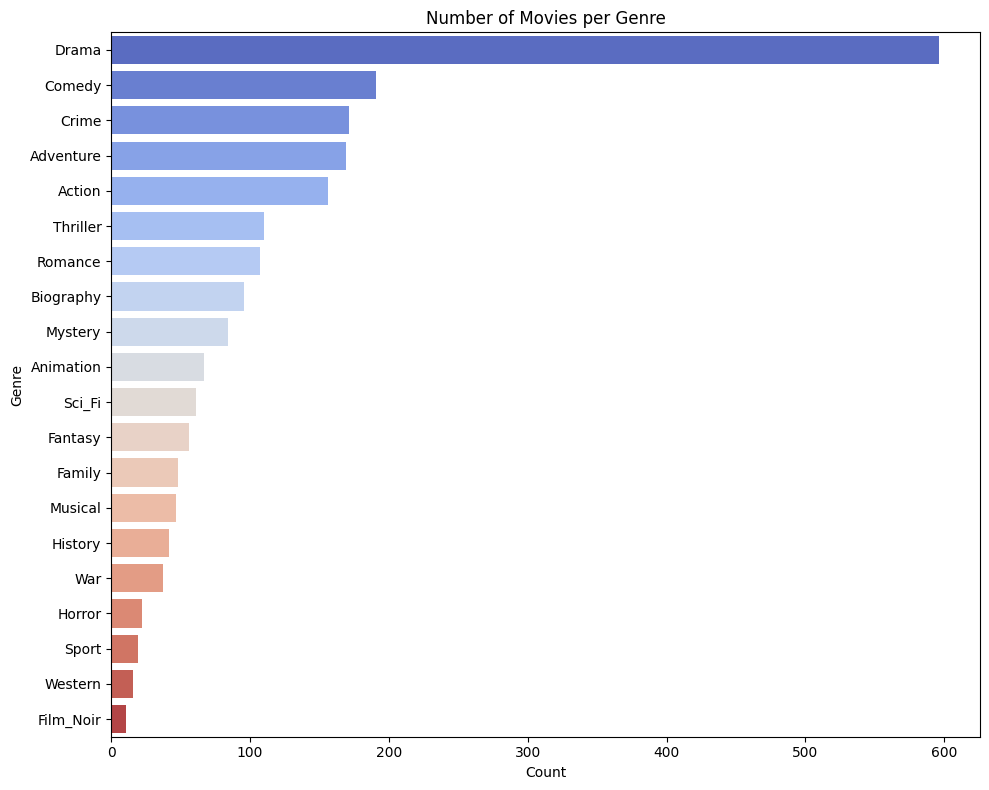

In [26]:
# count the number of movies per genre
genre_counts = df_genres['Genre'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']

# plot horizontal bar chart
plt.figure(figsize=(10, 8))
sns.barplot(
    data = genre_counts,
    y = 'Genre',
    x = 'Count',
    hue = 'Genre',
    palette = 'coolwarm',
    legend = False
)

plt.title('Number of Movies per Genre')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

## One-Hot Encoding

### One-Hot Encode the Genre column.

In [29]:
# store dropped genre value in a variable
dropped_genre_value = sorted(df_genres['Genre'].dropna().unique())[0]

df_genres_encoded = pd.get_dummies(df_genres['Genre'], prefix='Genre', drop_first=True)

# merge the one-hot encoded genres back into genres
df_genres = pd.concat([df_genres, df_genres_encoded], axis=1)

# group by Series_Title and aggregate by taking the max (since 0/1 values)
df_genres_grouped = df_genres.groupby('Series_Title', as_index=False).max()

# merge df1 with df_genres_grouped based on the series title
df1 = pd.merge(df1, df_genres_grouped, on='Series_Title', how='left')

# drop the original genre columns
df1.drop(columns=['Genre_x', 'Genre_y'], inplace=True)

# display merged dataframe
print(df1.head(3))

               Series_Title  Released_Year Certificate  Runtime  IMDB_Rating  \
0  The Shawshank Redemption         1994.0           A    142.0          9.3   
1             The Godfather         1972.0           A    175.0          9.2   
2           The Dark Knight         2008.0          UA    152.0          9.0   

   Meta_score  No_of_Votes        Gross  Genre_Adventure  Genre_Animation  \
0        80.0      2343110   28341469.0            False            False   
1       100.0      1620367  134966411.0            False            False   
2        84.0      2303232  534858444.0            False            False   

   ...  Genre_History  Genre_Horror  Genre_Musical  Genre_Mystery  \
0  ...          False         False          False          False   
1  ...          False         False          False          False   
2  ...          False         False          False          False   

   Genre_Romance  Genre_Sci_Fi  Genre_Sport  Genre_Thriller  Genre_War  \
0          False   

### One-Hot Encode the Certificate column.

In [31]:
# store dropped value in a variable
dropped_certificate_value = sorted(df1['Certificate'].dropna().unique())[0]

df_certificate_encoded = pd.get_dummies(df1['Certificate'], prefix='Certificate', drop_first=True)

# merge the one-hot encoded certificate back into df1
df1 = pd.concat([df1, df_certificate_encoded], axis=1)

# drop the original cerificate column
df1.drop(columns=['Certificate'], inplace=True)

# display merged dataframe
print(df1.head(3))

               Series_Title  Released_Year  Runtime  IMDB_Rating  Meta_score  \
0  The Shawshank Redemption         1994.0    142.0          9.3        80.0   
1             The Godfather         1972.0    175.0          9.2       100.0   
2           The Dark Knight         2008.0    152.0          9.0        84.0   

   No_of_Votes        Gross  Genre_Adventure  Genre_Animation  \
0      2343110   28341469.0            False            False   
1      1620367  134966411.0            False            False   
2      2303232  534858444.0            False            False   

   Genre_Biography  ...  Genre_Thriller  Genre_War  Genre_Western  \
0            False  ...           False      False          False   
1            False  ...           False      False          False   
2            False  ...           False      False          False   

   Certificate_Approved  Certificate_G  Certificate_PG  Certificate_PG_13  \
0                 False          False           False          

## Investigate & Adjust the Gross

### Check the scale of the Gross column.

In [34]:
print(df1['Gross'].describe())

count    8.300000e+02
mean     6.790728e+07
std      1.097546e+08
min      1.305000e+03
25%      3.245338e+06
50%      2.345744e+07
75%      8.010324e+07
max      9.366622e+08
Name: Gross, dtype: float64


Findings:

The mean is significantly higher than the median, which suggests the data is right-skewed (a few very high-grossing movies may be pulling the average up).

A huge range between the minimum and maximum values. The gross earnings vary from a few thousand dollars to nearly a billion.

## Correlation Check

### Check if any columns are highly correlated.

In [38]:
# create a copy of the dataframe
df2 = df1.copy()
df2.drop(columns=['Series_Title'], inplace=True)

In [39]:
# set continuous columns
continuous_columns = ['Released_Year', 'Runtime', 'Gross', 'IMDB_Rating', 'Meta_score', 'No_of_Votes']

# identify columns that are one-hot encoded (i.e., the categorical variables)
one_hot_columns = df2.columns.difference(continuous_columns)

# convert one-hot encoded columns (categorical) to integers (0 or 1)
df2[one_hot_columns] = df1[one_hot_columns].apply(lambda col: col.map({True: 1, False: 0}).fillna(col))

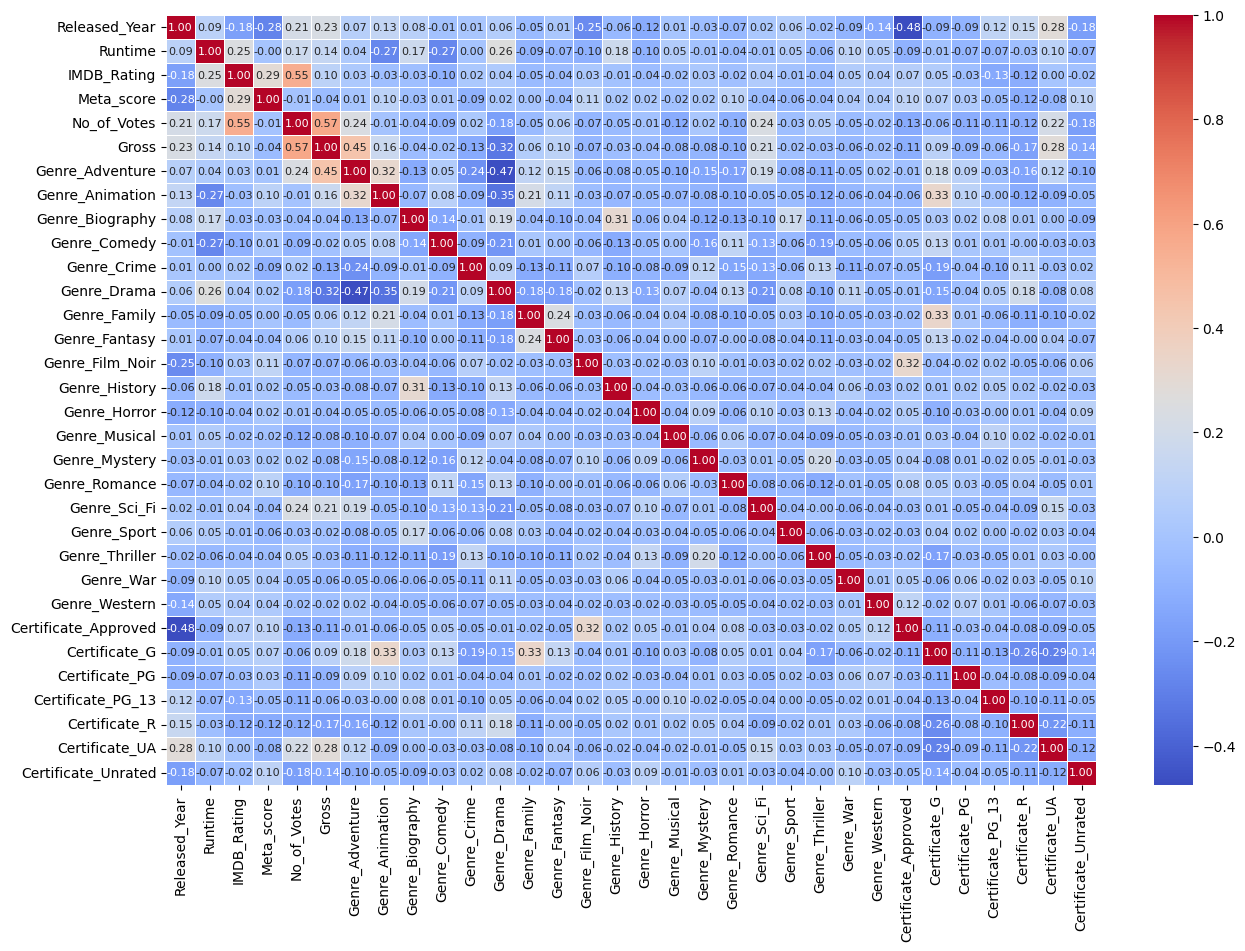

In [40]:
# Calculate the correlation matrix
correlation_matrix = df2.corr()

# lot a heatmap
plt.figure(figsize=(15, 10))  # Adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size': 8}, linewidths=0.5)
plt.show()

## Model

In [42]:
# define the features (X) and target variable (y)
X = df2.drop(columns=['Gross'])
y = df2['Gross']

# split the data first
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# fit scaler only on X_train and then transform both X_train and X_test
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create the model
model = LinearRegression()

# train the model
model.fit(X_train, y_train)

# make predictions on the test set
y_pred = model.predict(X_test)

# calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

# display metrics
print(f"R-squared: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

R-squared: 0.5838904671517746
Mean Absolute Error: 50461860.49200408
Mean Squared Error: 5994260307257544.0


### Prediction Function

In [44]:
# define a function to predict an IMDB rating for a movie
def predict_movie_metrics(genre, released_year, runtime, imdb_rating, certificate, meta, votes):
    # start the input data with the basic numeric fields
    input_data = {
        'Released_Year': [released_year],
        'Runtime': [runtime],
        'IMDB_Rating': [imdb_rating],
        'Meta_score': [meta],
        'No_of_Votes': [votes]
    }

    # set all certificate columns to 0, then set the one matching the input to 1
    for col in certificate_columns:
        input_data[col] = [1 if col == f'Certificate_{certificate}' else 0]

    # set all genre columns to 0, then set the ones matching the input list to 1
    for col in genre_columns:
        genre_name = col.replace('Genre_', '').replace('_', '-')
        input_data[col] = [1 if genre_name in genre else 0]

    # create the input DataFrame
    input_df = pd.DataFrame(input_data)
    feature_columns = X.columns
    input_df = input_df[feature_columns]

    # Predict and return the result
    predicted_gross = model.predict(input_df)[0]

    return predicted_gross

### Predict

In [51]:
# load the input file
df_input = pd.read_excel('movie-gross-input.xlsx')

# store predictions
predictions = []

# define the list of certificate and genre columns dynamically
certificate_columns = [col for col in df2.columns if col.startswith('Certificate_')]
genre_columns = [col for col in df2.columns if col.startswith('Genre_')]

# loop through each row and predict
for idx, row in df_input.iterrows():
    raw_genre = row['Genre']
    genres = [g.strip() for g in raw_genre.split(',')]
    predicted_gross = predict_movie_metrics(
        genre=genres,
        released_year=row['Released_Year'],
        runtime=row['Runtime'],
        certificate=row['Certificate'],
        imdb_rating=row['IMDB_Rating'],
        meta=row['Meta_score'],
        votes=row['No_of_Votes']
    )
    formatted_gross = f"{predicted_gross:,.0f}"
    predictions.append(formatted_gross)
    
# add predictions to the dataframe
df_input['Predicted_Gross'] = predictions

# display the results
print(df_input[['Series_Title', 'Predicted_Gross']])

# save predictions to an output excel file
df_input.to_excel('movie-gross-output.xlsx', index=False)

print('\nPredictions have been saved to movie-gross-output.xlsx')

                   Series_Title Predicted_Gross
0                   Toy Story 4     187,743,145
1               The Black Phone     136,183,970
2                        Wicked     159,751,363
3  Kinsgmen: The Secret Service     221,979,123
4               It Ends With Us     178,691,105
5                  Monsters Inc     265,855,029

Predictions have been saved to movie-gross-output.xlsx


In [49]:
# pip install openpyxl

Note: you may need to restart the kernel to use updated packages.
